In [ ]:
!pip install lightning > /dev/null

# Improving classification tasks

There are several techniques you can use to improve the accuracy of a Convolutional Neural Network (CNN) model:

- **Data preprocessing**: Proper data preprocessing is crucial for improving model accuracy. This includes normalizing pixel values, resizing images to a consistent size, and handling class imbalances if present.

- **Hyperparameter tuning**: Experiment with different hyperparameters such as learning rate, batch size, number of filters, filter sizes, and network architecture. You can use techniques like grid search or random search to find the optimal combination of hyperparameters that yield the best performance.

- **Batch Normalization**: Batch normalization is a technique that normalizes the inputs to a layer for each mini-batch. It helps in stabilizing and accelerating the training process, as well as reducing the sensitivity of the model to the initialization of weights.

- **Different network architectures**: Experiment with different CNN architectures, such as VGGNet, ResNet, Inception, or DenseNet. These architectures have been designed to address specific challenges in image recognition tasks and can significantly impact model performance.

![](https://miro.medium.com/v2/resize:fit:1400/1*n16lj3lSkz2miMc_5cvkrA.jpeg)

- **Data augmentation**: This technique involves artificially increasing the size of your training dataset by creating modified versions of existing images. Common data augmentation techniques include random cropping, flipping, rotation, scaling, and adjusting brightness or contrast. Data augmentation helps the model generalize better and reduces overfitting.

![](https://miro.medium.com/v2/resize:fit:2000/1*eepf79k7yQs-IQHYQd-xxA.jpeg)

- **Transfer Learning**: If you have a small dataset, you can leverage pre-trained CNN models that have been trained on large datasets like ImageNet. You can use the pre-trained model as a starting point and fine-tune it on your specific dataset. This allows the model to benefit from the learned features of the pre-trained model, improving accuracy.

![](https://miro.medium.com/v2/resize:fit:1400/0*xNjEPIZmPvKeqss6)






## Basic imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

import torchvision
from torchvision.datasets import MNIST, CIFAR10

from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.models import resnet18, ResNet18_Weights

import torchmetrics

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger

## Improving the accuracy of the CIFAR10 Data set

While CNNs have achieved remarkable success on various image classification tasks, training a CNN on the CIFAR-10 dataset can be challenging due to several factors:

1. Small Image Size: CIFAR-10 images are relatively small, with a resolution of 32x32 pixels. This limited size can make it challenging for CNNs to capture complex features and patterns. CNNs often perform better on larger images where they can learn more intricate details and spatial relationships. The small image size may lead to reduced representational capacity and limited feature extraction capabilities.

2. Limited Training Data: CIFAR-10 has a relatively small number of training examples, with only 50,000 images in the training set (5,000 images per class). Deep neural networks, including CNNs, typically require a large amount of training data to generalize well and avoid overfitting. With limited training data, it can be challenging to train a complex CNN architecture effectively.

3. High Variance in Classes: The CIFAR-10 classes are diverse and visually distinct, ranging from airplanes and cars to birds and dogs. This high variance in classes can make it challenging for a CNN to learn a comprehensive set of features that generalize well across all categories. The network might struggle to capture the intricate details and variations within each class.



### Loading and visualizing the data

In [ ]:
train_dataset = CIFAR10(root="./cifar", train=True, transform=ToTensor(), download=True)
test_dataset = CIFAR10(root="./cifar", train=False, transform=ToTensor(), download=True)

train_dataset, val_dataset = random_split(train_dataset, lengths=[45000, 5000])

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

tensor([9, 5, 0, 4, 0])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


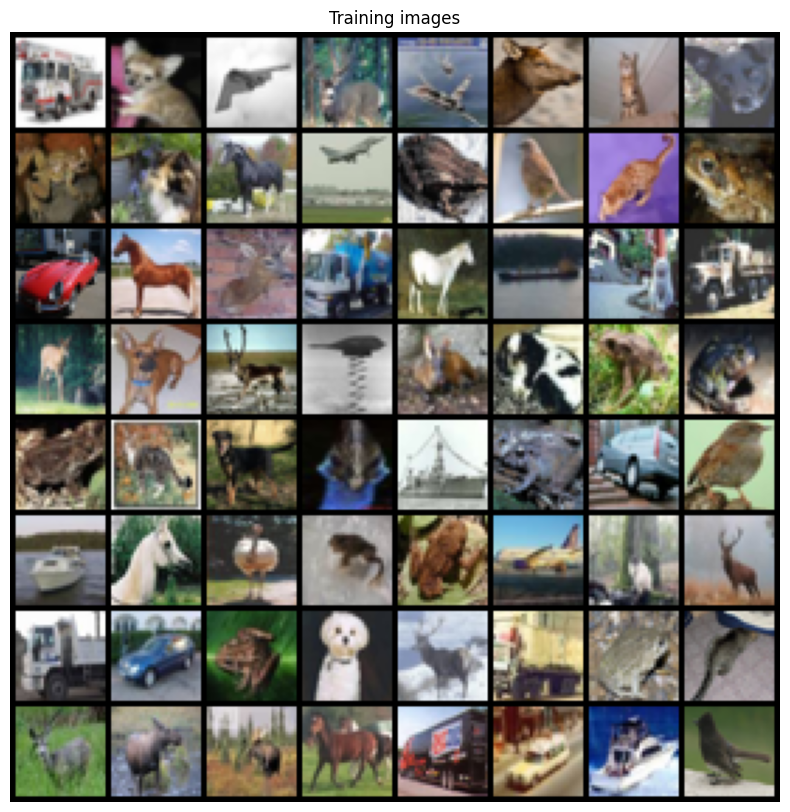

In [ ]:
images, labels = next(iter(train_loader))

one_hot = torch.nn.functional.one_hot(labels)

print(labels[:5])
print(one_hot[:5])

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], padding=2,normalize=True), (1, 2, 0)))
plt.show()

## Different network architectures

While creating a new CNN architecture can be a valuable research endeavor, it often requires a deep understanding of the underlying principles, extensive experimentation, and a large dataset. For many practical applications, using a well-established CNN architecture can be a more efficient and effective approach, allowing you to focus on fine-tuning and adapting the model to your specific task.

There are several compelling reasons why one might choose to use an existing CNN architecture instead of creating a new one from scratch:

1. Proven Performance: Established CNN architectures have been extensively tested and proven to achieve excellent performance on various computer vision tasks. These architectures have been developed and refined by researchers over time, incorporating years of expertise and insights.

2. Time and Resource Efficiency: Designing a new CNN architecture from scratch requires significant time, effort, and computational resources. It involves extensive experimentation, hyperparameter tuning, and training on large datasets. By using an existing architecture, you can save valuable time and resources, as the architecture has already been optimized and validated.

3. Transfer Learning: Many pre-trained CNN models are readily available for transfer learning. Transfer learning allows you to leverage the knowledge learned from a large dataset (e.g., ImageNet) and fine-tune the pre-trained model on your specific task, even with a smaller dataset. This approach often leads to faster convergence and better performance compared to training a new model from scratch.

4. Community Support and Documentation: Popular CNN architectures have extensive documentation, tutorials, and community support. This makes it easier to understand, implement, and troubleshoot the architecture. Additionally, pre-trained models, code implementations, and pre-trained weights are often readily available, simplifying the process of getting started with the architecture.

5. Domain-Specific Architectures: Some CNN architectures have been specifically designed for certain domains or tasks. For example, architectures like YOLO (You Only Look Once) and Faster R-CNN are tailored for object detection, while U-Net is widely used for image segmentation. Using these domain-specific architectures can provide better performance for specific tasks.

Some of the most common architectures are:

- **LeNet**: One of the earliest CNN architectures, LeNet was designed for handwritten digit recognition. It consists of convolutional and pooling layers followed by fully connected layers.
- **AlexNet**: AlexNet won the ImageNet Large Scale Visual Recognition Challenge in 2012, bringing CNNs into the spotlight. It introduced the use of ReLU activation and dropout regularization.
- **VGGNet**: VGGNet is known for its simplicity and uniformity, using small (3x3) convolutional filters and increasing the depth of the network.
- **GoogleNet (Inception)**: Inception modules use multiple filters of different sizes within the same layer to capture multi-scale features. It also introduced the concept of network width and depth optimization.
- **ResNet**: ResNet introduced residual connections, allowing the network to skip connections between layers, which helps in addressing the vanishing gradient problem in very deep networks.
- **DenseNet**: DenseNet connects each layer to every other layer in a feed-forward fashion, encouraging feature reuse and reducing the number of parameters.
- **MobileNet**: Designed for mobile and embedded devices, MobileNet uses depthwise separable convolutions to reduce computational complexity.

### AlexNet

![](https://viso.ai/wp-content/smush-webp/2024/04/alexNet-architecture-1060x446.png.webp)

AlexNet, developed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton in 2012, played a pivotal role in the history of deep learning and CNNs. It marked a key event in the history of deep learning, showcasing the strengths of CNN architectures and its vast applications.

Before AlexNet, people were skeptical about whether deep learning could be applied successfully to very large datasets. However, a team of researchers were driven to prove that Deep Neural Architectures were the future, and succeeded in it; AlexNet exploded the interest in deep learning post-2012.

![](https://viso.ai/wp-content/uploads/2024/02/imagenet-winners-by-year.jpg)

The Deep Learning model was designed to compete in the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2012. This is an annual competition that benchmarks algorithms for image classification. Before ImageNet, there was no availability of a large dataset to train Deep Neural Networks. As a result, consequently, ImageNet also played a role in the success of Deep Learning.

In that competition, AlexNet performed exceptionally well. It significantly outperformed the runner-up model by reducing the top-5 error rate from 26.2% to 15.3%.

Its importance can be attributed to several key factors:

1. **ImageNet Breakthrough**: AlexNet won the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2012, achieving a top-5 error rate of 15.3%, significantly outperforming the second-best entry with a top-5 error rate of 26.2%. This was a remarkable achievement at the time, as it demonstrated the potential of deep learning and CNNs in large-scale image classification tasks.

2. **Deep Learning Renaissance**: Before AlexNet, neural networks had been relatively less popular due to the challenges of training deep architectures. AlexNet's success reignited interest in deep learning and CNNs, leading to what is often referred to as the "deep learning renaissance." It showed that deep neural networks, when trained on large datasets with powerful GPUs, could achieve unprecedented performance in computer vision tasks.

3. **Use of GPUs**: AlexNet was one of the first CNN architectures to leverage the power of Graphical Processing Units (GPUs) for training. By utilizing GPUs, AlexNet could train a large network with millions of parameters efficiently. This demonstrated the practicality of using GPUs for deep learning, which became a standard practice in the field.

4. **Architectural Innovations**: AlexNet introduced several architectural innovations that have become fundamental building blocks in modern CNNs:

    - Deep Architecture: AlexNet consisted of eight layers, including five convolutional layers and three fully connected layers. This demonstrated the effectiveness of deep architectures, as previous CNNs were relatively shallow.
    - ReLU Activation: AlexNet popularized the use of the Rectified Linear Unit (ReLU) activation function, which helped address the vanishing gradient problem and allowed for faster and more efficient training.
    - Dropout Regularization: AlexNet introduced dropout as a regularization technique to prevent overfitting. Dropout randomly sets a fraction of the input units to zero during training, forcing the network to learn more robust features.



## Transfer Learning


A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task.

If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task.

We will consider a large Conv net trained on the [ImageNet data set](http://www.image-net.org/). ImageNet is an image database organized according to the WordNet hierarchy (currently only the nouns), in which each node of the hierarchy is depicted by hundreds and thousands of images.

![Image Samples](https://adriancolyer.files.wordpress.com/2016/04/imagenet-fig4l.png?w=600)

There are two ways to leverage a pre-trained network: feature extraction and fine-tuning.

### Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

Convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.

![Feature extraction](https://blogs.rstudio.com/tensorflow/posts/2017-12-14-image-classification-on-small-datasets/images/swapping_fc_classifier.png)

### Using RESNET18

ResNet-18 is a popular CNN architecture introduced in the ResNet family by Microsoft Research in 2015. The "18" in the name refers to the number of convolutional layers in the network. ResNet-18 is known for its simplicity, efficiency, and strong performance on various image classification tasks.

The architecture addressed the vanishing gradient problem in very deep networks. ResNet introduced residual connections, allowing the network to skip connections between layers. This enabled the training of much deeper networks, such as ResNet-50, ResNet-101, and ResNet-152, with improved performance.

![](https://www.researchgate.net/publication/366608244/figure/fig1/AS:11431281109643320@1672145338540/Structure-of-the-Resnet-18-Model.jpg)

In [ ]:
entrypoints = torch.hub.list('pytorch/vision', force_reload=True)
for e in entrypoints:
    print(e)

Downloading: "https://github.com/pytorch/vision/zipball/main" to /home/hub/.cache/torch/hub/main.zip


alexnet
convnext_base
convnext_large
convnext_small
convnext_tiny
deeplabv3_mobilenet_v3_large
deeplabv3_resnet101
deeplabv3_resnet50
densenet121
densenet161
densenet169
densenet201
efficientnet_b0
efficientnet_b1
efficientnet_b2
efficientnet_b3
efficientnet_b4
efficientnet_b5
efficientnet_b6
efficientnet_b7
efficientnet_v2_l
efficientnet_v2_m
efficientnet_v2_s
fcn_resnet101
fcn_resnet50
get_model_weights
get_weight
googlenet
inception_v3
lraspp_mobilenet_v3_large
maxvit_t
mc3_18
mnasnet0_5
mnasnet0_75
mnasnet1_0
mnasnet1_3
mobilenet_v2
mobilenet_v3_large
mobilenet_v3_small
mvit_v1_b
mvit_v2_s
r2plus1d_18
r3d_18
raft_large
raft_small
regnet_x_16gf
regnet_x_1_6gf
regnet_x_32gf
regnet_x_3_2gf
regnet_x_400mf
regnet_x_800mf
regnet_x_8gf
regnet_y_128gf
regnet_y_16gf
regnet_y_1_6gf
regnet_y_32gf
regnet_y_3_2gf
regnet_y_400mf
regnet_y_800mf
regnet_y_8gf
resnet101
resnet152
resnet18
resnet34
resnet50
resnext101_32x8d
resnext101_64x4d
resnext50_32x4d
s3d
shufflenet_v2_x0_5
shufflenet_v2_x1_0
sh

In [ ]:
resnet_model = torch.hub.load("pytorch/vision", "resnet18", weights=None)
# resnet_model.fc = nn.Linear(512, 3)

Using cache found in /home/hub/.cache/torch/hub/pytorch_vision_main


In [ ]:
class CIFARCnnModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        """Initialize the CIFARCnnModel class.

            Args:
                model (torch.nn.Module): The CNN model to be used for training and inference.
                learning_rate (float): The learning rate for the optimizer.
        """
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        """Forward pass of the model.

            Args:
                x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28)

            Returns:
                torch.Tensor: Output tensor after passing through the model
        """
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        # true_labels = true_labels - 1
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        """Perform a training step.

            Args:
                batch: A batch of training data containing features and labels.
                batch_idx (int): Index of the current batch in the epoch.

            Returns:
                torch.Tensor: Loss tensor to be optimized
        """
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        """Perform a validation step.

            Args:
                batch: A batch of validation data containing features and labels.
                batch_idx (int): Index of the current batch in the validation set.

            Returns:
                torch.Tensor: Validation loss tensor
        """
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        with torch.no_grad():
            loss, true_labels, predicted_labels = self._shared_step(batch)
            self.test_acc(predicted_labels, true_labels)
            self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        """Configure the optimizer for training.

            Returns:
                torch.optim.Optimizer: Optimizer for training
        """
        optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        return optimizer

In [ ]:
class Cifar10DataModule(L.LightningDataModule):
    def __init__(self, data_path="./cifar", batch_size=64, num_workers=0, train_transform=None, test_transform=None):
        super().__init__()
        self.batch_size = batch_size
        self.data_path = data_path
        self.num_workers = num_workers
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.prepare_data()
        self.setup()

    def prepare_data(self):
        CIFAR10(root=self.data_path, download=True)
        return

    def setup(self, stage=None):
        train = CIFAR10(
            root=self.data_path,
            train=True,
            transform=self.train_transform,
            download=False,
        )

        self.test = CIFAR10(
            root=self.data_path,
            train=False,
            transform=self.test_transform,
            download=False,
        )

        self.train, self.valid = random_split(train, lengths=[45000, 5000])

    def train_dataloader(self):
        train_loader = DataLoader(
            dataset=self.train,
            batch_size=self.batch_size,
            drop_last=True,
            shuffle=True,
            num_workers=self.num_workers,
        )
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(
            dataset=self.valid,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(
            dataset=self.test,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )
        return test_loader

In [ ]:
model_transform = Compose([
        Resize((128, 128)),
        ToTensor(),
    ])

cifar_cnn_model = CIFARCnnModel(model=resnet_model, learning_rate=0.1)
dm = Cifar10DataModule(num_workers=2, train_transform=model_transform, test_transform=model_transform)

trainer_cnn = L.Trainer(
    max_epochs=15,
    logger=CSVLogger(save_dir="logs/", name="cifar-cnn-model"),
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=3)],
)

Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer_cnn.fit(model=cifar_cnn_model, datamodule=dm)

Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.7 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.758    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

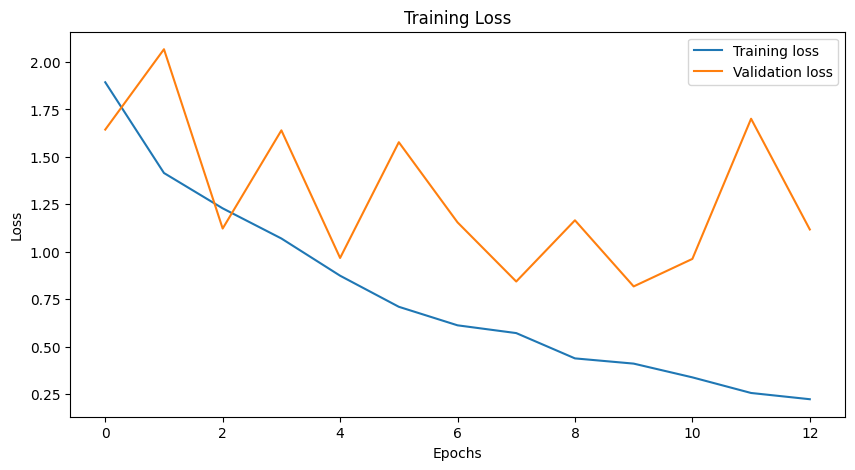

In [ ]:
# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics = pd.read_csv(f"{trainer_cnn.logger.log_dir}/metrics.csv")
# Group the metrics by epoch and compute the mean loss for each epoch
df_epochs = metrics.groupby('epoch').mean()

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Loss')
# Plot the training loss over epochs
ax.plot(df_epochs['train_loss'], label="Training loss")
# Plot the validation loss over epochs
ax.plot(df_epochs['val_loss'], label="Validation loss")
# Set the title of the plot
ax.set_title("Training Loss")
# Add a legend to the plot
ax.legend(loc='upper right')

In [ ]:
trainer_cnn.test(datamodule=dm)

/opt/miniconda3/envs/ai/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Files already downloaded and verified


Restoring states from the checkpoint path at logs/cifar-cnn-model/version_1/checkpoints/epoch=12-step=9139.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/cifar-cnn-model/version_1/checkpoints/epoch=12-step=9139.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7182000279426575     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.7182000279426575}]

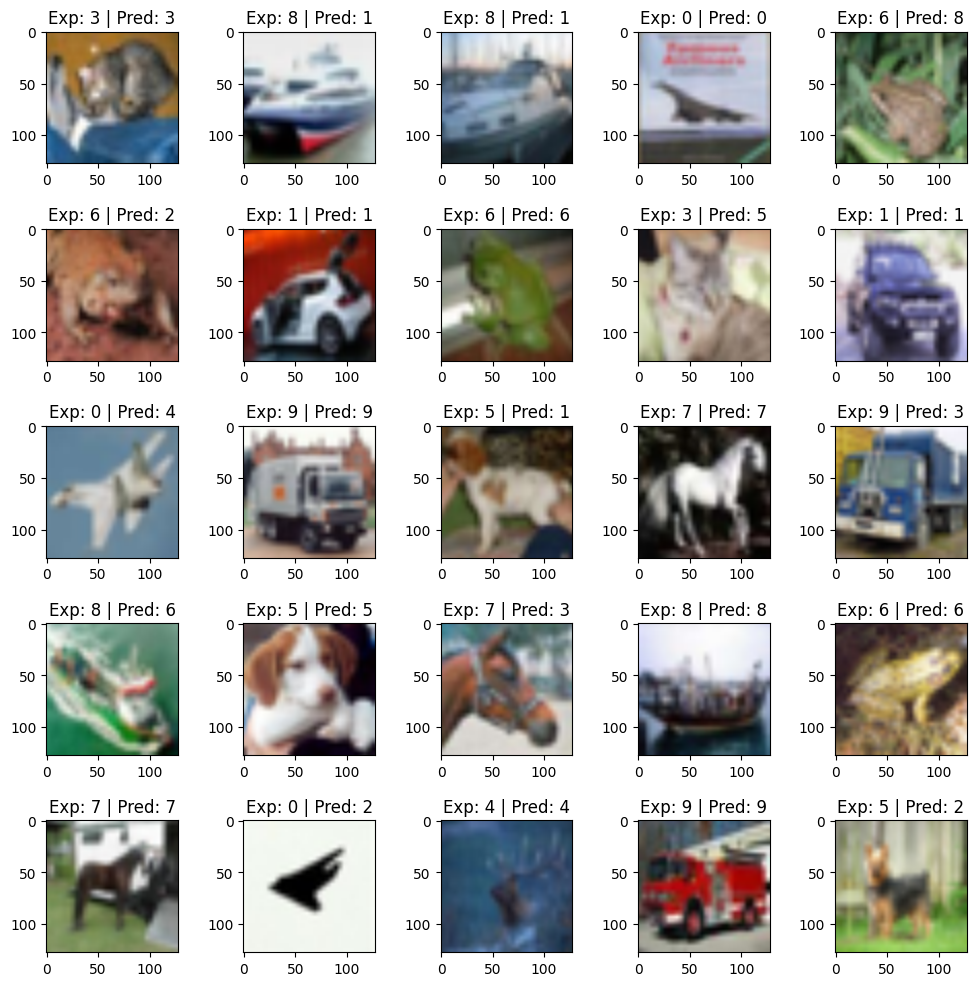

In [ ]:
# Create a 5x5 subplot figure
f, ax = plt.subplots(5, 5, figsize=(10, 10))
# Adjust the layout of the subplots to avoid overlapping
f.tight_layout(pad=1.)

test_batch = next(iter(dm.test_dataloader()))

# Iterate over the first 25 test images
for idx in range(25):
    # Calculate the row and column index for the subplot
    row = idx // 5
    col = idx % 5

    image = test_batch[0][idx].numpy()
    # image = np.reshape(image, (150, 150, 3))
    image = image.transpose((1, 2, 0))
    image = (image * 255.0).astype("uint8")

    label = test_batch[1][idx].item()

    ax[row, col].imshow(image)

    # Reshape the test data to match the model input shape
    test_data = np.reshape(test_batch[0][idx], (1, 3, 128, 128))

    # Forward pass of the model without gradient computation
    with torch.no_grad():
        # Get the model prediction for the test data
        prediction = cifar_cnn_model(test_data)

    # Set the title of the subplot with expected and predicted labels
    ax[row, col].set_title(f'Exp: {label} | Pred: {np.argmax(prediction)}')

## Data Augmentation

Overfitting is usually caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit.

One of the best approaches to improve generalization is to collect additional data.

![Overfitting-dataset size](https://miro.medium.com/v2/resize:fit:1400/1*L392ucqge-zTsOJYieRN7A.png)

Random data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. **The goal is that at training time, our model would never see the exact same picture twice**. This helps the model get exposed to more aspects of the data and generalize better.

Torchvision provides a range of data augmentation transformations such as:

- RandomCrop: Crops the image randomly to a specified size.
- RandomHorizontalFlip: Randomly flips the image horizontally with a given probability.
- RandomRotation: Rotates the image by a random angle.
- ColorJitter: Randomly changes the brightness, contrast, saturation, and hue of the image.
- RandomAffine: Applies random affine transformations like translation, rotation, scaling, and shearing.

In [ ]:
visualization_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((150, 150)),
        transforms.RandomCrop((128, 128)),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.RandomRotation(90),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # [0, 1] -> [-1, 1]
    ]
)

In [ ]:
images, labels = next(iter(dm.train_dataloader()))

transformed = [visualization_transform(i) for i in images]

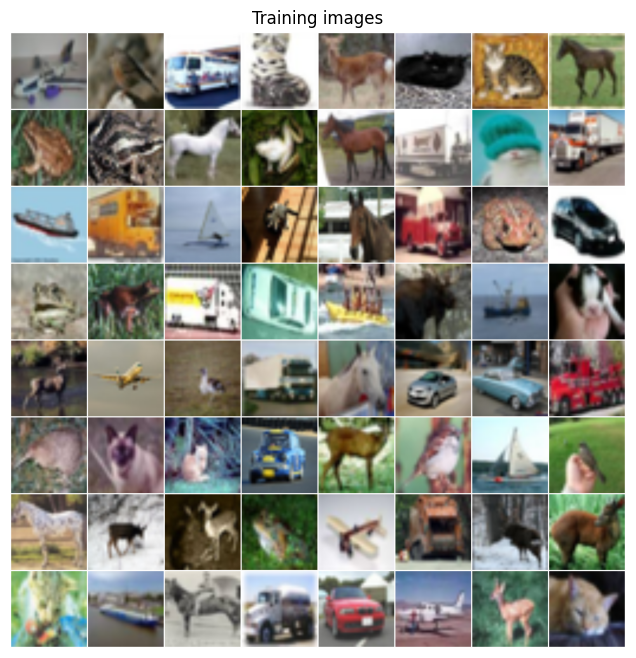

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64],
    padding=2,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)))
plt.show()

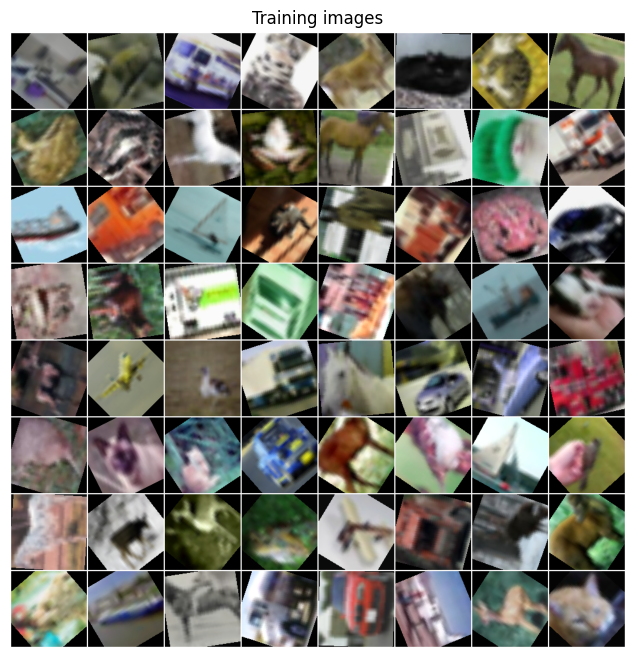

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    transformed[:64],
    padding=2,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)))
plt.show()

In [ ]:
train_transform = transforms.Compose(
    [
        transforms.Resize((150, 150)),
        transforms.RandomCrop((128, 128)),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.RandomRotation(90),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # [0, 1] -> [-1, 1]
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((150, 150)),
        transforms.CenterCrop((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

cifar_cnn_model = CIFARCnnModel(model=resnet_model, learning_rate=0.01)
dm = Cifar10DataModule(num_workers=2, train_transform=train_transform, test_transform=test_transform)

trainer_cnn = L.Trainer(
    max_epochs=30,
    logger=CSVLogger(save_dir="logs/", name="cifar-cnn-model"),
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=5)],
)

Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer_cnn.fit(model=cifar_cnn_model, datamodule=dm)

Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.7 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.758    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
trainer_cnn.test(datamodule=dm)

Files already downloaded and verified


Restoring states from the checkpoint path at logs/cifar-cnn-model/version_4/checkpoints/epoch=12-step=9139.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/cifar-cnn-model/version_4/checkpoints/epoch=12-step=9139.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8245999813079834     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8245999813079834}]

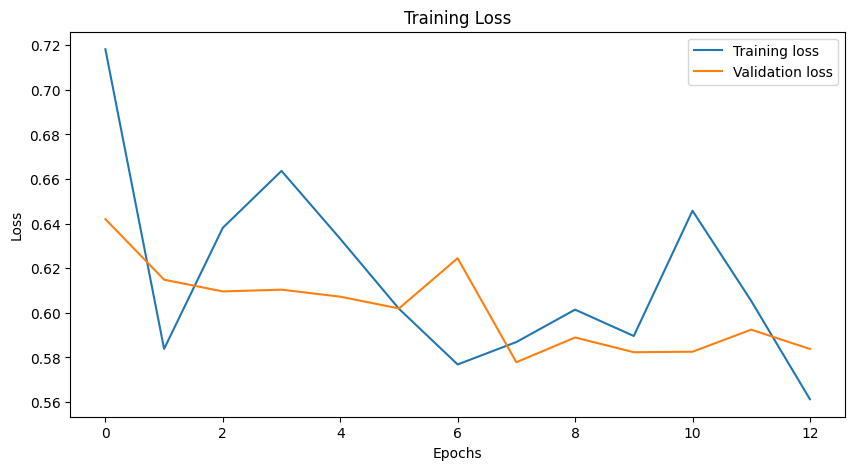

In [ ]:
# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics = pd.read_csv(f"{trainer_cnn.logger.log_dir}/metrics.csv")
# Group the metrics by epoch and compute the mean loss for each epoch
df_epochs = metrics.groupby('epoch').mean()

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Loss')
# Plot the training loss over epochs
ax.plot(df_epochs['train_loss'], label="Training loss")
# Plot the validation loss over epochs
ax.plot(df_epochs['val_loss'], label="Validation loss")
# Set the title of the plot
ax.set_title("Training Loss")
# Add a legend to the plot
ax.legend(loc='upper right')

## Fine tuning

Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning. Fine-tuning consists in unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

![Fine tuning](https://blog.keras.io/img/imgclf/vgg16_modified.png)

In [ ]:
pytorch_model = torch.hub.load('pytorch/vision:v0.13.0', 'resnet18', weights='IMAGENET1K_V1')

Downloading: "https://github.com/pytorch/vision/zipball/v0.13.0" to /home/hub/.cache/torch/hub/v0.13.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/hub/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 31.8MB/s]


In [ ]:
pytorch_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in pytorch_model.parameters():
   param.requires_grad = False

pytorch_model.fc = torch.nn.Linear(512, 10)

In [ ]:
pytorch_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
weights = ResNet18_Weights.IMAGENET1K_V1
preprocess_transform = weights.transforms()
preprocess_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
dm = Cifar10DataModule(batch_size=64, num_workers=4,
                       train_transform=preprocess_transform,
                       test_transform=preprocess_transform)

cifar_cnn_model = CIFARCnnModel(model=pytorch_model, learning_rate=0.01)

Files already downloaded and verified


In [ ]:
trainer = L.Trainer(
    max_epochs=50,
    accelerator="gpu",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
)

trainer.fit(model=cifar_cnn_model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.2 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
trainer_cnn.test(datamodule=dm)

/opt/miniconda3/envs/ai/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Files already downloaded and verified


Restoring states from the checkpoint path at logs/cifar-cnn-model/version_4/checkpoints/epoch=12-step=9139.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/cifar-cnn-model/version_4/checkpoints/epoch=12-step=9139.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.27410000562667847    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.27410000562667847}]

In [ ]:
# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics = pd.read_csv(f"{trainer_cnn.logger.log_dir}/metrics.csv")
# Group the metrics by epoch and compute the mean loss for each epoch
df_epochs = metrics.groupby('epoch').mean()

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Loss')
# Plot the training loss over epochs
ax.plot(df_epochs['train_loss'], label="Training loss")
# Plot the validation loss over epochs
ax.plot(df_epochs['val_loss'], label="Validation loss")
# Set the title of the plot
ax.set_title("Training Loss")
# Add a legend to the plot
ax.legend(loc='upper right')